<h1 style='text-align: center;'> 
Physics-Informed Neural Networks (PINNs)
</h1>

`Narváez J.`
<p style='text-align: justify;'>

<p style='text-align: justify;'>  
In this notebook, we will introduce the concept of Physics-Informed Neural Networks (PINNs). We will create simple examples of how it works for solving ODES. </p>

# Solving ODES with PINNs

<p style='text-align: justify;'>  
The process of solving a differential equation with a neural network using the ODE itself to define the cost function is known as <b> physics-informed neural network</b>.
</p>

Let's consider the next general ODE:

<div id="ODE"></div>

$$
\begin{equation} \label{ODE} \tag{1}
 f(x, u(x), u^\prime(x), u^{\prime\prime}(x), \cdots, u^{(n)}(x))=0 \hspace{0.5cm}\text{for } x\in D,
\end{equation}
$$

<p style='text-align: justify;'> 
subject to some Boundary Conditions in $\partial D$. Here, $u(x)$ is the function to be evaluated in its domain $D$. Now, we chose a trial solution $\Psi(x)$ such that, by construction, it satisfied the boundary condition, as follows,
</p>

<div id="Trial"></div>

$$
\begin{equation} \label{Trial} \tag{2}
 \Psi(x, w) = A(x) + F(x, NN(x, w)),
\end{equation}
$$

<p style='text-align: justify;'> 
where $NN(x, w)$ is a single-output neural network whose weights and biases are denoted by $w$, $F$ is some function involving the neural network, and $A(x)$ does not contain tunable parameters that satisfy the boundary condition. In this way, $F$ is constructed such that it doesn't contribute to the BC's.
</p>

<p style='text-align: justify;'> 
If $\Psi(x)$ was the exact solution, then it has to satisfy the condition:
</p>

<div id="PsiReq"></div>

$$
\begin{equation} \label{PsiReq} \tag{3}
 f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))=0 \hspace{0.5cm}\text{for all} x\in D,
\end{equation}
$$

Thus, let turn this condition to our cost function. This is,

<div id="CostF"></div>

$$
\begin{equation} \label{CostF} \tag{4}
 C(w) = \frac{1}{2} \sum_{x \in D} \left(f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))\right)^2.
\end{equation}
$$

## Dirichlet's Boundary Conditions

## Example 1

Let's solve the next ordinary differential equation:

<div id="ODEsystem"></div>

$$
\begin{equation} \label{ODESystem} \tag{5}
  u^\prime (t)= f(u,t), 
\end{equation}
$$

with $t \in T$ and a known initial condition, $u(0) = u_0$. As we saw above, we approximate the solution for the trial solution ([2](#Trial)), which in this case takes the form:

<div id="TrialExample"></div>

$$
\begin{equation} \label{TrialExample} \tag{6}
  \Psi(t, w)= u_0 + t \cdot NN(t, w), 
\end{equation}
$$

then, it follows the BC's immediately. Replacing ([6](#TrialExample)) and ([5](#ODEsystem)) in ([4](#CostF)) we get

<div id="CostExample"></div>

$$
\begin{equation} \label{CostExample} \tag{7}
  C(w)= \frac{1}{2}\sum_i \left(\Psi^\prime(t_i)-f(\Psi(t_i), t_i)\right)^2.
\end{equation}
$$

The choice of $t_i$ could be done in many ways: it can be random, it can be a grid, etc.

<p style='text-align: justify;'> 
From the above equation, we see that when we take the gradient of C with respect to parameters: weights and biases, $\nabla_w$, then we don't calculate only partial derivatives with respect to $w$, but total derivatives with respect to inputs $t$. It can be complicated and expensive. For this task, we will use libraries that calculate this efficiently.
</p>

Now, let's consider the case $f(u, t) = \cos{(2\pi t)}$ with $T=[0, 1]$ and the initial condition $u_0 = 1$.

We will use the library $\texttt{Flux}$ to implement the code. You can find more information about this tool [here](https://fluxml.ai/Flux.jl/stable/).

In [1]:
using Distributions # Create uniform randomly distribution
using Flux          # Machine learning
using LaTeXStrings  # Type LaTeX syntax
using LinearAlgebra # Linear Algebra's operations
using Plots         # Display plots
using Statistics    # Basic statistics functionality.
using ProgressMeter  # Progress Bar.

In [2]:
function Der(f, t; ϵ)
    #=-----------------------------------------------
    Calculates the first derivative of f with respect 
    to t using the second-order method of centre
    derivation.
    -----------------------------------------------=#
    df = (f(t+ϵ)-f(t-ϵ))/(2*ϵ)
    return df
end;

function Der2(f, t; ϵ)
    #=-----------------------------------------------
    Calculates the second derivative of f with respect 
    to t using the second-order method of centre
    derivation.
    -----------------------------------------------=#
    df2 = (f(t+ϵ)+f(t-ϵ)-2*f(t))/(ϵ^2)
    return df2
end;

In [3]:
Ψ(t; NN, Ψ0) = t*NN(t) + Ψ0 # Trial solution

Ψ (generic function with 1 method)

In [4]:
loss(Ψ1, ODE, T; ϵ) = 0.5*mean(abs2(ODE(Ψ1, t; ϵ)) for t in T) # Loss function

loss (generic function with 1 method)

In [5]:
# We define a NN with: 1 input layer, 2 hidden layers and 1 output layer
NNODE = Chain(t -> [t], # Take in a scalar and transform it into an array
            Dense(1, 32, tanh), # It uses the hyperbolic tangent as activation function
            Dense(32,1), first) # Take first value, i.e. return a scalar
NNODE(1.0)

0.25051330567093405

In [6]:
u0 = 1. # Initial condition
T = 0:1f-2:1f0 # Domain of solution V
ϵ = sqrt(eps(Float32)); # Parameter Δx for differentiation

In [7]:
Ψ1(t) = Ψ(t; NN=NNODE, Ψ0 = u0)

Ψ1 (generic function with 1 method)

In [8]:
ODE1(Ψ, t; ϵ) = Der(Ψ, t; ϵ) - cos(2π*t)

ODE1 (generic function with 1 method)

In [9]:
loss1() = loss(Ψ1, ODE1, T; ϵ)

loss1 (generic function with 1 method)

In [10]:
lr = 1e-3 # learning rate
epochs = 5000 # Number of iterations
logstep = 100; # Period to store loss in history

In [11]:
opt = Flux.Adam(lr); # ADAM method (Stochastic optimization)
data = Iterators.repeated((), 1);

In [12]:
function Train(data, loss, opt, params, epochs, logstep)
    hist = zeros(Float64, epochs ÷ logstep) 
    p = Progress(epochs ÷ logstep)
    for epoch in 1:epochs
        Flux.train!(loss, params, data, opt)
        if epoch % logstep == 0
            ProgressMeter.next!(p)
            hist[epoch ÷ logstep] = loss()          # store current loss in loss-history
        end
    end
    return(hist)                                        # return loss-history
end

Train (generic function with 1 method)

In [13]:
Hist1 = Train(data, loss1, opt, Flux.params(NNODE), epochs, 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


In [14]:
F_target1(t) = 1.0 + sin(2π*t)/2π # Analytical solution

F_target1 (generic function with 1 method)

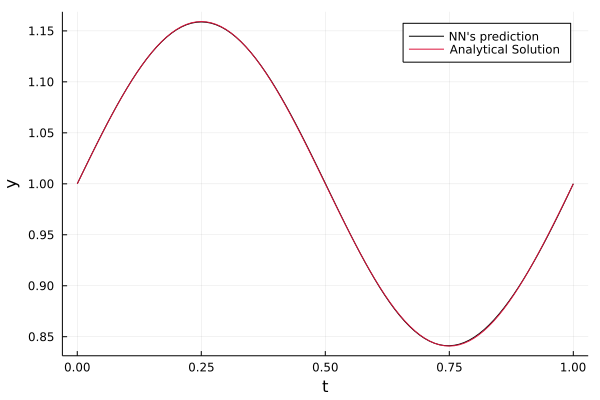

In [15]:
plot(T,Ψ1.(T),color = "black", label="NN's prediction")
plot!(T, F_target1.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

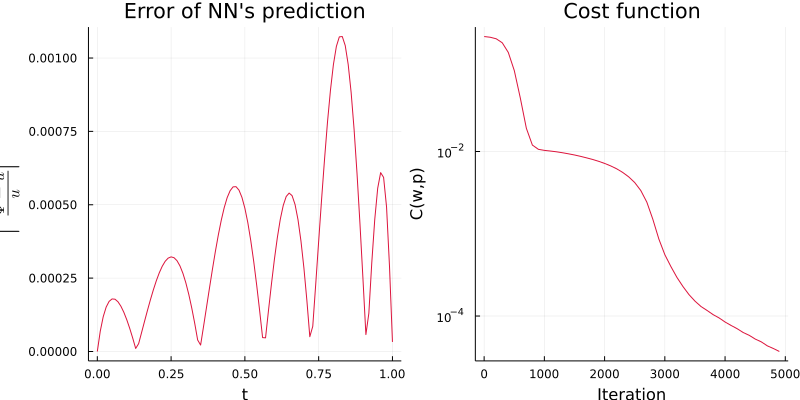

In [16]:
p1 = plot(T,abs.((Ψ1.(T) - F_target1.(T))./F_target1.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:logstep:epochs, Hist1, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 2

Let's consider an exponential decay of a physical quantity $u(t)$ represented by the next ODE:

<div id="solve_expdec"></div>
$$
\begin{equation} \label{solve_expdec} \tag{10}
  u'(t) = -\gamma u(t),
\end{equation}
$$

and the initial condition $u(0)=1$ and $t\in[0,1]$. In this example, we'll take $\gamma = 2$.

The analytical solution of the IVP in ([10](#solve_expdec)) is

<div id="AnSOl2"></div>
$$
\begin{equation}\label{AnSOL2} \tag{11}
  u(t) = u_0 \exp\left(-\gamma t\right).
\end{equation}
$$

In [17]:
NNODE2 = Chain(t -> [t], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE2(1.0)

0.6483808047510843

In [18]:
Ψ2(t) = Ψ(t; NN=NNODE2, Ψ0 = 10)

Ψ2 (generic function with 1 method)

In [19]:
gamma = 2
ODE2(Ψ, t; ϵ) = Der(Ψ, t; ϵ) + gamma * Ψ2(t)

ODE2 (generic function with 1 method)

In [20]:
loss2() = loss(Ψ2, ODE2, T; ϵ) # Loss function

loss2 (generic function with 1 method)

In [21]:
Hist2 = Train(data, loss2, opt, Flux.params(NNODE2), epochs, 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


In [22]:
F_target2(t) = 10*exp(-gamma*t) # Analytical solution

F_target2 (generic function with 1 method)

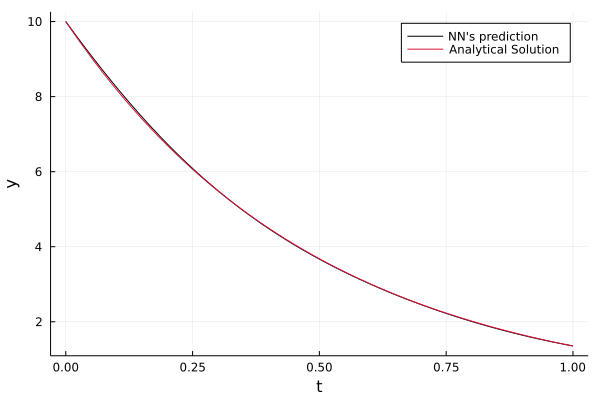

In [23]:
plot(T,Ψ2.(T),color = "black", label="NN's prediction")
plot!(T, F_target2.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

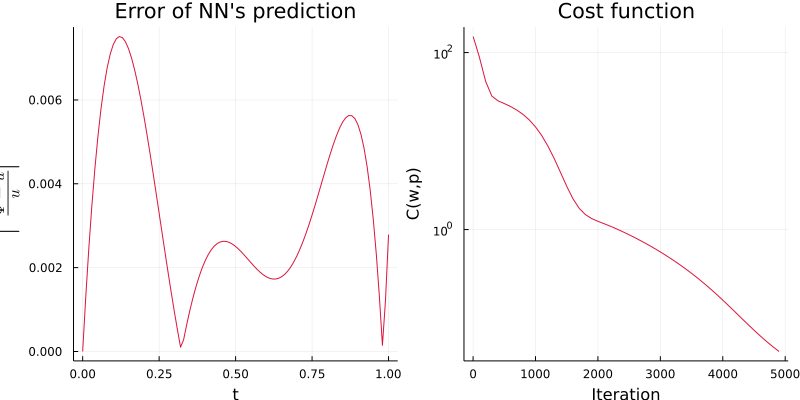

In [24]:
p1 = plot(T,abs.((Ψ2.(T) - F_target2.(T))./F_target2.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:logstep:epochs, Hist2, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 3

- ODE: 

<div id="ExamODE3"></div>
$$
\begin{equation} \label{ExamODE3} \tag{12}
  u'(t) + \left(t + \frac{1+3t^2}{1+t+t^3}\right)u= t^3+ 2t + t^2\left(\frac{1+3t^2}{1+t+t^3}\right),
\end{equation}
$$

with $u(0)=1$ and $t \in [0,1]$.

- Analytical solution:

<div id="AnSOL3"></div>
$$
\begin{equation} \label{ANSOL3} \tag{13}
  u(t) = \frac{1}{1+t+t^3}e^{-\frac{t^2}{2}} + t^2.
\end{equation}
$$

In [25]:
NNODE3 = Chain(t -> [t], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE3(1.0)

0.12099644920189907

In [26]:
Ψ3(t) = Ψ(t; NN=NNODE3, Ψ0 = 1)

Ψ3 (generic function with 1 method)

In [27]:
ODE3(Ψ, t; ϵ) = Der(Ψ, t; ϵ) + (t + (1+3*t^2)/(1+t+t^3))*Ψ(t) - (t^3 + 2*t + t^2*((1+3*t^2)/(1+t+t^3)))

ODE3 (generic function with 1 method)

In [28]:
loss3() = loss(Ψ3, ODE3, T; ϵ) # Loss function

loss3 (generic function with 1 method)

In [29]:
Hist3 = Train(data, loss3, opt, Flux.params(NNODE3), epochs, logstep);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


In [30]:
F_target3(t) = exp(-t^2 / 2)/(1+t+t^3)+t^2 # Analytical solution

F_target3 (generic function with 1 method)

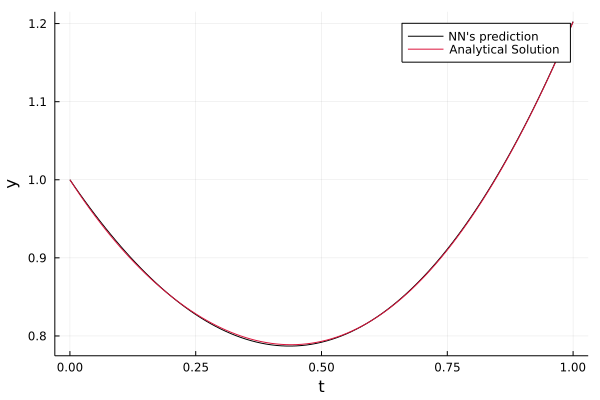

In [31]:
plot(T,Ψ3.(T),color = "black", label="NN's prediction")
plot!(T, F_target3.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

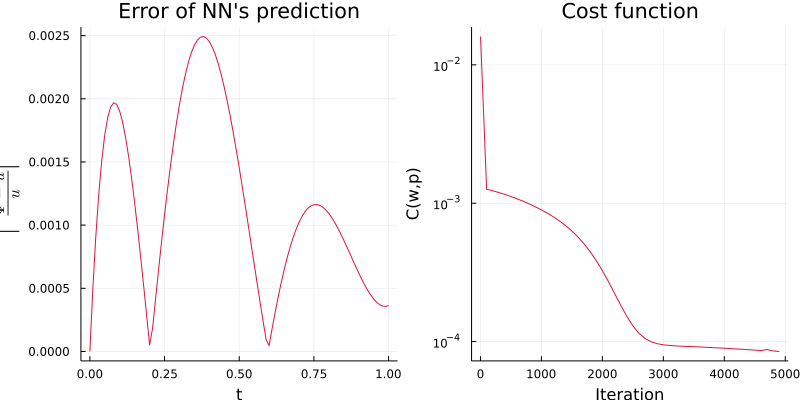

In [32]:
p1 = plot(T,abs.((Ψ3.(T) - F_target3.(T))./F_target3.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:logstep:epochs, Hist3, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Mixed boundary condition

## Example 1

- ODE: 

<div id="ExamODE4"></div>
$$
\begin{equation} \label{ExamODE4} \tag{14}
  \frac{d^2u(t)}{dt^2} + \frac{du}{dt}+u = -e^{-t}\cos{(t)},
\end{equation}
$$

with $u(0)=0$ and $u^\prime(0)=1$, for $t \in [0,2]$.

- Analytical solution:

<div id="AnSOL5"></div>
$$
\begin{equation} \label{ANSOL5} \tag{15}
  u(t) = e^{-t}\sin{(t)}.
\end{equation}
$$



- Trial Solution:

<div id="TriSOL5"></div>
$$
\begin{equation} \label{TriSOL5} \tag{16}
  u(t) = t + t^2 NN (t, w).
\end{equation}
$$


In [33]:
NNODE4 = Chain(t -> [t], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE4(1.0)

0.08270917833662986

In [34]:
Ψ4(t) = t + (t^2)*NNODE4(t) # Trial solution

Ψ4 (generic function with 1 method)

In [35]:
T2 = 0:1f-2:2f0 # Domain of solution V

0.0f0:0.01f0:2.0f0

In [36]:
ODE4(Ψ, t; ϵ) = Der2(Ψ, t; ϵ) + Der(Ψ, t; ϵ) + Ψ(t) + exp(-t)*cos(t)

ODE4 (generic function with 1 method)

In [37]:
loss4() =  loss(Ψ4, ODE4, T2; ϵ) # Loss function

loss4 (generic function with 1 method)

In [38]:
Hist4 = Train(data, loss4, opt, Flux.params(NNODE4), epochs, logstep);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


In [39]:
F_target4(t) = exp(-t)*sin(t) # Analytical solution

F_target4 (generic function with 1 method)

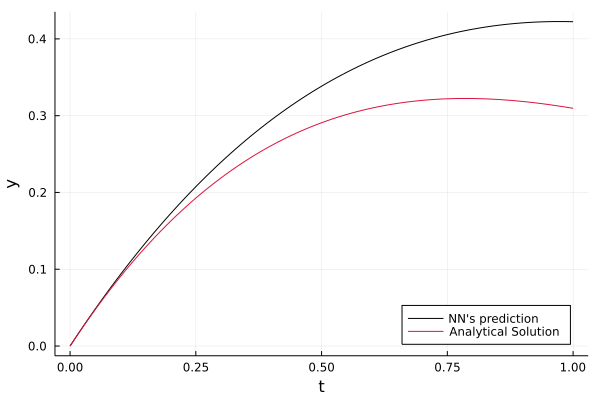

In [40]:
plot(T,Ψ4.(T),color = "black", label="NN's prediction", legend=:bottomright)
plot!(T, F_target4.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

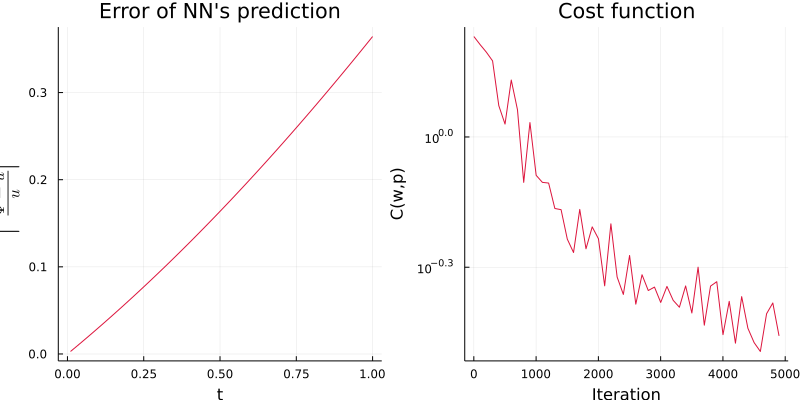

In [41]:
p1 = plot(T,abs.((Ψ4.(T) - F_target4.(T))./F_target4.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:logstep:epochs, Hist4, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## References

1. `Lagaris, Isaac & Likas, Aristidis & Fotiadis, Dimitrios. (1998). Artificial neural networks for solving ordinary and partial differential equations. IEEE Transactions on Neural Networks. 9. 987-1000. 10.1109/72.712178.`

2. `Rackauckas, Chris. (2020). Introduction to Scientific Machine Learning through Physics-Informed Neural Networks.`https://book.sciml.ai/course/

3. `Larrañaga, Eduard. (2022). Notes of Physics Informed Neural Networks (PINNs).`